In [71]:
from RegridSami import latlonalt_to_cart

from RegridSami import *


In [2]:
from utility_programs.read_routines import SAMI

In [122]:
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator, griddata
import numpy as np


from datetime import datetime
from tqdm.auto import tqdm
import xarray as xr

import matplotlib.pyplot as plt

import cartopy.crs as ccrs

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


In [23]:
samipath = '/petastore/phil/Prasoon_satellite_project/more_runs/20130317/sami-gitm-coupled/'

In [90]:
nz, nf, nlt, nt=SAMI.get_grid_elems_from_parammod(samipath)
old_shape=[nlt, nf, nz]

In [91]:
grid=SAMI.get_sami_grid(samipath, nlt, nf, nz)

In [94]:
mask = np.where(grid['alt'] < 2500)
grid2={}
for k in grid.keys():
    grid2[k]=grid[k][mask].flatten()

In [96]:
in_cart=latlonalt_to_cart(grid2['glat'], grid2['glon'], grid2['malt']).T

In [97]:
tri = Delaunay(in_cart)

In [98]:
in_cart.shape

(1330560, 3)

In [359]:
latout=np.arange(-90, 90, 1)
lonout=np.arange(0, 360, 4)
altout=np.arange(200, 2200, 100)

out_lats=[]
out_lons=[]
out_alts=[]

for a in latout:
    for o in lonout:
        for l1 in altout:
            out_lats.append(a)
            out_lons.append(o)
            out_alts.append(l1)

out_cart=latlonalt_to_cart(
    out_lats, out_lons, np.array(out_alts) + 6371)

In [360]:
data, times=SAMI.read_to_nparray(
                samipath, datetime(2011,3,16), cols='edens', pbar=True,
                skip_time_check=True)

reading SAMI data:   0%|          | 0/597 [00:00<?, ?it/s]

In [361]:
interpd = []

for t in tqdm(range(len(times))):
    interp = LinearNDInterpolator(tri, data['data']['edens'][:,:,:,t][mask].flatten(), )
    interpd.append(interp(out_cart.T))

  0%|          | 0/597 [00:00<?, ?it/s]

In [362]:
ds=xr.Dataset(coords={
                'time': (['time'], times),
                'alt': (['alt'], altout),
                'lat': (['lat'], latout),
                'lon': (['lon'], lonout)},)
varname=list(data['data'].keys())[0]

In [363]:
ds[varname]=(('time', 'lat', 'lon', 'alt'),
             np.array(interpd).reshape(
                 len(times), len(latout), len(lonout), len(altout)))

In [364]:
ds

<xarray.Dataset>
Dimensions:  (time: 597, alt: 20, lat: 180, lon: 90)
Coordinates:
  * time     (time) datetime64[ns] 2011-03-16 ... 2011-03-18T01:39:54
  * alt      (alt) int64 200 300 400 500 600 700 ... 1700 1800 1900 2000 2100
  * lat      (lat) int64 -90 -89 -88 -87 -86 -85 -84 ... 83 84 85 86 87 88 89
  * lon      (lon) int64 0 4 8 12 16 20 24 28 ... 332 336 340 344 348 352 356
Data variables:
    edens    (time, lat, lon, alt) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

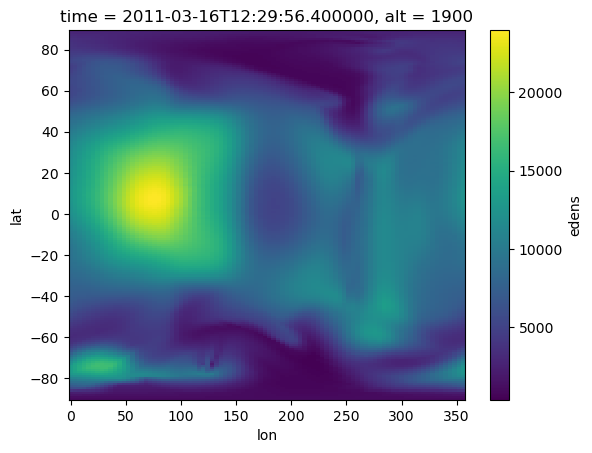

In [367]:
ds.edens.isel(time=150, alt=17).plot(x='lon')

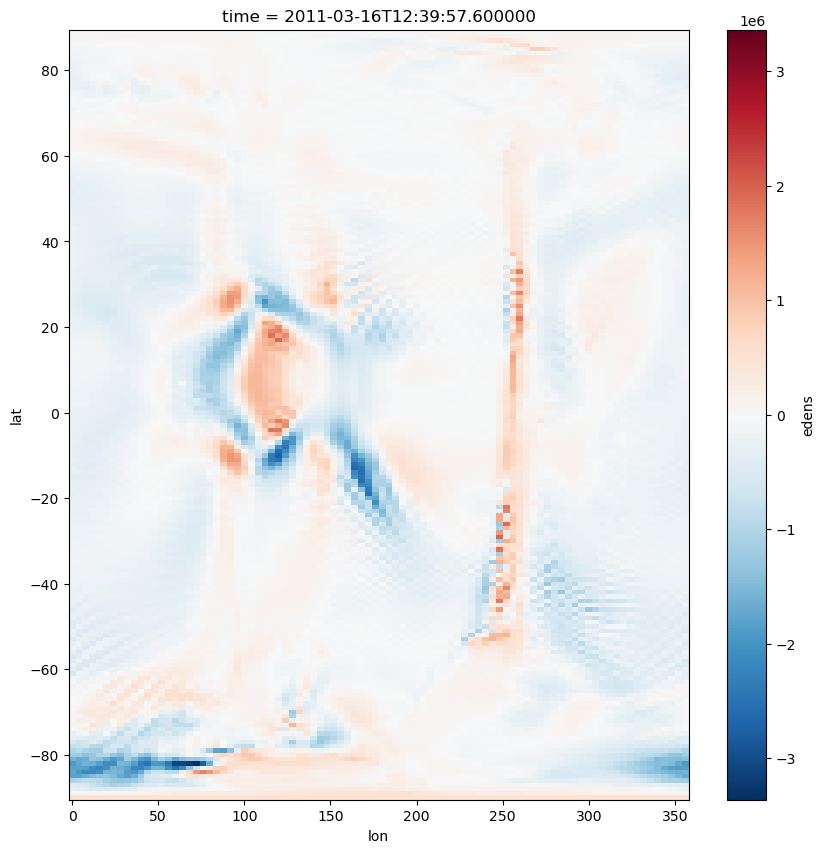

In [373]:
plt.figure(figsize=(10,10))
ds.edens.integrate('alt').diff('time', 2).isel(time=150).plot(x='lon')
plt.show()

In [ ]:
nearest_pt = [nlt, nf, nz]

[[nlt-1, nf-1, nz-1],
]

In [68]:
import itertools

In [ ]:
nlt = 30
nf = 50
nz = 70

In [70]:
for i in itertools.product([nlt-1, nlt, nlt+1], [nf-1, nf, nf+1], [nz-1,nz, nz+1]):
    print(i)

(79, 71, 255)
(79, 71, 256)
(79, 71, 257)
(79, 72, 255)
(79, 72, 256)
(79, 72, 257)
(79, 73, 255)
(79, 73, 256)
(79, 73, 257)
(80, 71, 255)
(80, 71, 256)
(80, 71, 257)
(80, 72, 255)
(80, 72, 256)
(80, 72, 257)
(80, 73, 255)
(80, 73, 256)
(80, 73, 257)
(81, 71, 255)
(81, 71, 256)
(81, 71, 257)
(81, 72, 255)
(81, 72, 256)
(81, 72, 257)
(81, 73, 255)
(81, 73, 256)
(81, 73, 257)


In [109]:
grid=SAMI.get_sami_grid(samipath, nlt, nf, nz)

In [110]:
# mask = np.where(grid['alt'] < 2500)
grid2={}
for k in grid.keys():
    grid[k]=grid[k].flatten()

In [111]:
in_cart=latlonalt_to_cart(grid['glat'], grid['glon'], grid['malt']).T

In [112]:
nns = find_pairs(in_cart, out_cart)

In [113]:
nns.shape, out_cart.shape, in_cart.shape

((1296000,), (3, 1296000), (1474560, 3))

In [114]:
nns[0]

90649

In [161]:
out_cart.T[0], in_cart[nns[0]]

(array([ 4.02357706e-13,  0.00000000e+00, -6.57100000e+03]),
 array([ 4.1405315e+00,  9.9534409e+01, -6.5797036e+03], dtype=float32))

In [115]:
i = np.unravel_index(nns[0], [nlt, nf, nz])

In [116]:
i

(4, 66, 25)

In [144]:
def is_inside_cube(x, y, z, xs, ys, zs):
    """Check if a point is inside a cube.

    Args:
        x (float): x coordinate of point
        y (float): y coordinate of point
        z (float): z coordinate of point
        xs (list-like): cartesian x coordinates of cube vertices
        ys (list-like): cartesian y coordinates of cube vertices
        zs (list-like): cartesian z coordinates of cube vertices

    Returns:
        bool: True if point is inside cube, False otherwise
    """
    if (x > min(xs)) and (x < max(xs)) and (y > min(ys)) and (y < max(ys)) \
            and (z > min(zs)) and (z < max(zs)):
        return True
    else:
        return False


In [145]:
out_cart.shape

(3, 1296000)

In [278]:
invalid_points = []
invalid_points2 = []
oks = []
outsides = []

x_to_use = []
y_to_use = []
z_to_use = []
good_out_idxs = []
good_src_idxs = []

for in_i, out_i in enumerate(tqdm(nns)):
    idx = np.unravel_index(out_i, old_shape)
    id_pt = []
    xs = []
    ys = []
    zs = []
    
    
    for newidx_3d in itertools.product([idx[0]-1, idx[0], idx[0]+1],
                                    [idx[1]-1, idx[1], idx[1]+1],
                                    [idx[2]-1,idx[2], idx[2]+1]):
        valid=False
        try:
            newidx_1d = np.ravel_multi_index(newidx_3d, old_shape)
            valid=True
        except ValueError:
            try:
                newidx_1d = np.ravel_multi_index([nlt-1, newidx_3d[1], newidx_3d[2]], old_shape)
                valid=True
            except:
                try:
                    newidx_1d = np.ravel_multi_index([0, newidx_3d[1], newidx_3d[2]], old_shape)
                    valid=True
                except:
                    invalid_points2.append(out_i)
                # invalid_points2.append(out_i)
        except:
            invalid_points.append(out_i)
            
        if valid:
            id_pt.append(newidx_1d)
            xs.append(in_cart[newidx_1d,0])
            ys.append(in_cart[newidx_1d,1])
            zs.append(in_cart[newidx_1d,2])
            
    if len(xs) == len(ys) == len(zs) == 27:
        oks.append(in_i)
            
        if not is_inside_cube(out_cart[0,in_i], out_cart[1,in_i], out_cart[2,in_i], xs, ys, zs):
            outsides.append(in_i)
        else:
            x_to_use.append(xs)
            y_to_use.append(ys)
            z_to_use.append(zs)
            good_out_idxs.append(in_i)
            good_src_idxs.append(id_pt)
        

    # break

  0%|          | 0/1296000 [00:00<?, ?it/s]

In [330]:
idx

(36, 70, 167)

In [335]:
invalid_points = []
invalid_points2 = []
oks = []
outsides = []

x_to_use = []
y_to_use = []
z_to_use = []
good_out_idxs = []
good_src_idxs = []


for in_i, out_i in enumerate(tqdm(nns)):
    idx = np.unravel_index(out_i, old_shape)
    id_pt = []
    xs = []
    ys = []
    zs = []
    
    valid=False
    
    default_pts=True
    try_one = False
    try_two = False
    
    
    for newidx_3d in itertools.product([idx[0]-1, idx[0], idx[0]+1],
                                    [idx[1]-1, idx[1], idx[1]+1],
                                    [idx[2]-1,idx[2], idx[2]+1]):
        if default_pts:
            try:
                newidx_1d = np.ravel_multi_index(newidx_3d, old_shape)
                id_pt.append(newidx_1d)
                xs.append(in_cart[newidx_1d,0])
                ys.append(in_cart[newidx_1d,1])
                zs.append(in_cart[newidx_1d,2])
                valid=True
            except:
                id_pt = []
                xs = []
                ys = []
                zs = []
                default_pts=False
                try_one=True
            
        if not valid and try_one:
            for newidx_3d in itertools.product([nlt-1, idx[0], idx[0]+1],
                                        [idx[1]-1, idx[1], idx[1]+1],
                                        [idx[2]-1,idx[2], idx[2]+1]):
                try:
                    newidx_1d = np.ravel_multi_index(newidx_3d, old_shape)
                    id_pt.append(newidx_1d)
                    xs.append(in_cart[newidx_1d,0])
                    ys.append(in_cart[newidx_1d,1])
                    zs.append(in_cart[newidx_1d,2])
                    valid=True
                    try_one = True
                except:
                    id_pt = []
                    xs = []
                    ys = []
                    zs = []
                    valid=False
                    try_one=False
                    try_two=True

        if not valid and try_two:
            for newidx_3d in itertools.product([idx[0]-1, idx[0], 0],
                                        [idx[1]-1, idx[1], idx[1]+1],
                                        [idx[2]-1,idx[2], idx[2]+1]):
                try:
                    newidx_1d = np.ravel_multi_index(newidx_3d, old_shape)
                    id_pt.append(newidx_1d)
                    xs.append(in_cart[newidx_1d,0])
                    ys.append(in_cart[newidx_1d,1])
                    zs.append(in_cart[newidx_1d,2])
                    valid=True
                    try_two=True
                except:
                    id_pt = []
                    xs = []
                    ys = []
                    zs = []
                    valid=False
            
    if len(xs) == len(ys) == len(zs) == 27:
        oks.append(in_i)
            
        if not is_inside_cube(out_cart[0,in_i], out_cart[1,in_i], out_cart[2,in_i], xs, ys, zs):
            outsides.append(in_i)
        else:
            x_to_use.append(xs)
            y_to_use.append(ys)
            z_to_use.append(zs)
            good_out_idxs.append(in_i)
            good_src_idxs.append(id_pt)
    elif len(xs) != 0:
        break

    # break

  0%|          | 0/1296000 [00:00<?, ?it/s]

In [336]:
len(xs)

27

In [337]:
len(x_to_use), len(outsides), len(oks), len(invalid_points), len(invalid_points2)

(1261089, 4407, 1265496, 0, 0)

In [338]:
xs = np.array(xs)
x_to_use = np.array(x_to_use)

In [339]:
ys = np.array(ys)
y_to_use = np.array(y_to_use)

In [340]:
zs = np.array(zs)
z_to_use = np.array(z_to_use)

In [341]:
dists = np.sqrt((xs - x_to_use)**2 + (ys - y_to_use)**2 + (zs - z_to_use)**2)

In [342]:
np.max(dists)

17049.797

In [343]:
np.min(dists)

0.0

In [344]:
np.max(in_cart), np.max(out_cart)

(5622472.0, 8471.0)

In [345]:
np.max(in_cart[grid['alt'] < 2200])

8561.682

In [346]:
weights = 1/dists

/tmp/ipykernel_71084/2900369569.py:1: RuntimeWarning: divide by zero encountered in divide
  weights = 1/dists


In [347]:
weights.shape

(1261089, 27)

In [348]:
eddata = data['data']['edens']

In [349]:
eddata.shape

(80, 72, 256, 597)

In [350]:
regridded = np.zeros([len(times), len(out_alts)])
regridded[:] = np.nan

In [351]:
eddata.shape, np.array(good_src_idxs).shape, regridded.shape, np.array(good_out_idxs).shape

((80, 72, 256, 597), (1261089, 27), (597, 1296000), (1261089,))

In [352]:
for t in tqdm(range(len(times))):
    regridded[t][good_out_idxs] = np.sum(weights * np.take(eddata[:,:,:,t], np.array(good_src_idxs)), axis=1) / np.sum(weights, axis=1)

  0%|          | 0/597 [00:00<?, ?it/s]

/tmp/ipykernel_71084/176424368.py:2: RuntimeWarning: invalid value encountered in multiply
  regridded[t][good_out_idxs] = np.sum(weights * np.take(eddata[:,:,:,t], np.array(good_src_idxs)), axis=1) / np.sum(weights, axis=1)
/tmp/ipykernel_71084/176424368.py:2: RuntimeWarning: invalid value encountered in divide
  regridded[t][good_out_idxs] = np.sum(weights * np.take(eddata[:,:,:,t], np.array(good_src_idxs)), axis=1) / np.sum(weights, axis=1)


KeyboardInterrupt: 

In [353]:
regridded = np.zeros([len(out_alts)])
regridded[:] = np.nan

In [355]:
regridded[good_out_idxs] = np.sum(weights * np.take(eddata[:,:,:,400], np.array(good_src_idxs)), axis=1) / np.sum(weights, axis=1)

/tmp/ipykernel_71084/698585848.py:1: RuntimeWarning: invalid value encountered in divide
  regridded[good_out_idxs] = np.sum(weights * np.take(eddata[:,:,:,400], np.array(good_src_idxs)), axis=1) / np.sum(weights, axis=1)


In [356]:
ds=xr.Dataset(coords={
                'alt': (['alt'], altout),
                'lat': (['lat'], latout),
                'lon': (['lon'], lonout)},)
varname=list(data['data'].keys())[0]

In [357]:
ds[varname]=(('lat', 'lon', 'alt'),
             np.array(regridded).reshape(len(latout),
                                         len(lonout),
                                         len(altout)))

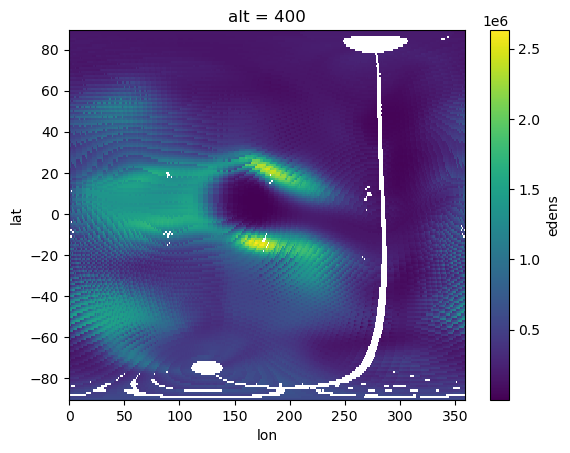

In [358]:
ds.edens.isel(alt=2).plot()

In [272]:
np.array(good_out_idxs).shape

(1274718,)

In [273]:
regridded.shape

(1296000,)

In [292]:
ds=xr.Dataset(coords={
                'alt': (['alt'], altout),
                'lat': (['lat'], latout),
                'lon': (['lon'], lonout)},)
varname=list(data['data'].keys())[0]

In [293]:
ds[varname]=(('lat', 'lon', 'alt'),
             np.array(regridded).reshape(len(latout),
                                         len(lonout),
                                         len(altout)))

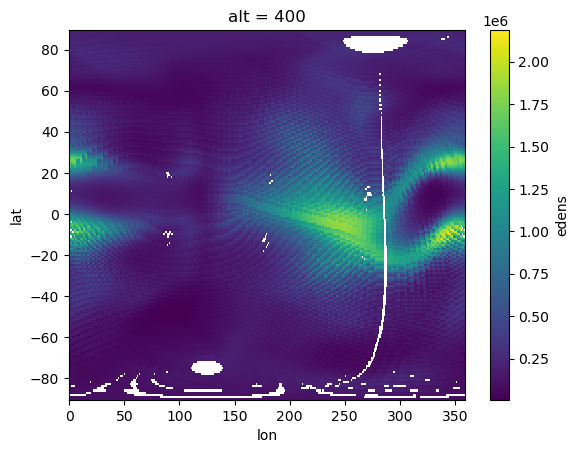

In [294]:
ds.edens.isel(alt=2).plot()

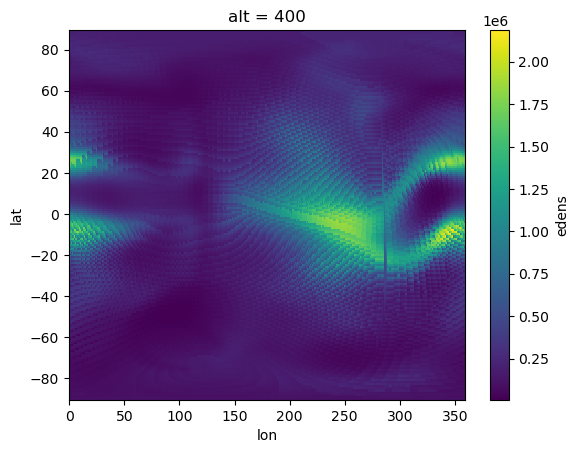

In [317]:
ds.edens.isel(alt=2).interpolate_na('lat').plot()

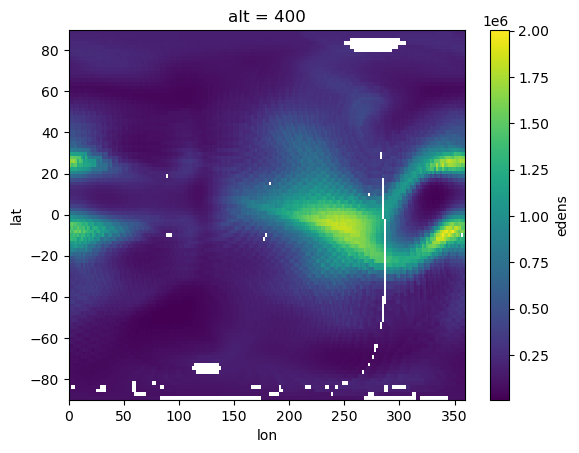

In [315]:
ds.edens.isel(alt=2).interp(lat=np.arange(-90,90,.3)).interp(lon=np.arange(0,360,.3), ).coarsen(lat=6, lon=6).mean().plot()

In [296]:
x = ds.lon.values
y = ds.lat.values

c = ds.edens.isel(alt=2).values


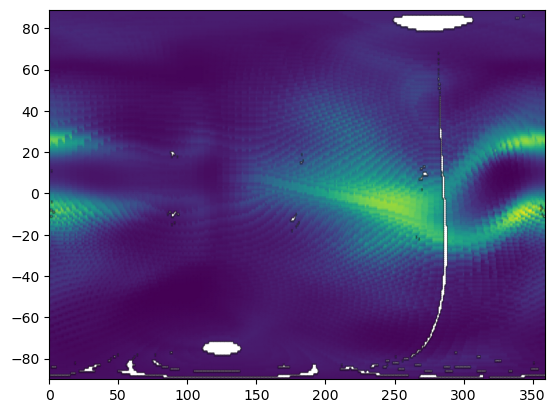

In [299]:
plt.pcolormesh(x, y, c, shading='gouraud')

In [223]:
3888000/20/360/27

20.0

In [175]:
out_cart[:,out_i]

array([-1429.36492339,  -492.16981259, -7112.11120494])

In [176]:
in_cart[in_i,:]

array([ 2085.2769, -5356.5854, -3029.2708], dtype=float32)

In [177]:
nns[in_i]

90387

In [178]:
out_i

90387

In [162]:
out_cart[:,i], in_cart[idx, :]

(array([-1317.28009746,  -823.12796078, -7307.74072508]),
 array([[ 2173.914 , -5877.6187, -1531.8738],
        [ 2174.2407, -5892.7295, -1484.9956],
        [ 2173.9988, -5880.1484, -1524.2432]], dtype=float32))

In [158]:
in_cart.shape

(1474560, 3)

In [172]:
np.unravel_index(out_i, old_shape)

(4, 65, 19)

In [173]:
nz, nf

(256, 72)

In [174]:
print(*out_cart[:,3])

4.207274078470732e-13 0.0 -6871.0


In [142]:
(len(invalid_points) + len(invalid_points2))/len(nns)

0.07988888888888888

In [143]:
len(invalid_points), len(invalid_points2)

(0, 103536)

No changes to indices:

In [124]:
len(invalid_points)/len(nns)

0.35220833333333335